In [1]:
#imports

import pandas as pd
import numpy as np
import joblib


import eli5
from eli5.sklearn import PermutationImportance
from matplotlib.colors import ListedColormap

import category_encoders as ce
from sklearn.experimental import enable_halving_search_cv
import warnings
from sklearn import tree
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, validation_curve, learning_curve, HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer, precision_score, accuracy_score, recall_score, confusion_matrix, fbeta_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt
import dataframe_image as dfi

C:\Users\moham\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
warnings.filterwarnings('ignore')

# Prep

In [16]:
final = pd.read_csv('Final Data/final_bees_av.csv').drop(columns=['Unnamed: 0'])

In [17]:
en = ce.OneHotEncoder(cols = 'Species', use_cat_names=True) # encoding the species features since it is categorical but not ordinal
final_en = en.fit_transform(final)

In [18]:
# splitting dataset into features and target
X = final_en.drop(columns = ['Present', 'Total'])
y = final_en['Present']

In [19]:
# some models use pca, so a pipeline is created to scale the data and then use pca to keep 95% of the variance
pca = PCA(0.95)
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('pca', pca)])
X_pca_scaled = pipe.fit_transform(X)

pca.explained_variance_ratio_ 

array([0.19636892, 0.07570987, 0.04617996, 0.04039124, 0.03496972,
       0.02891896, 0.02840672, 0.02657873, 0.02540471, 0.0235322 ,
       0.02314815, 0.02314815, 0.02314815, 0.02314815, 0.02314815,
       0.02314815, 0.02314815, 0.02314815, 0.02314815, 0.02278336,
       0.02265919, 0.0203423 , 0.02000007, 0.01907966, 0.01795071,
       0.01665425, 0.01502124, 0.01242031, 0.01113039, 0.01081619,
       0.00985302, 0.00874277, 0.00848631])

In [7]:
y.value_counts(normalize=True) #distribtion of the target variable

1    0.55773
0    0.44227
Name: Present, dtype: float64

# Models

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=40)

X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca_scaled, y,test_size=0.2, random_state=40)

In [8]:
# optimisation

def optimise(clf, params, X, y, name, metric, rfe):
    start = time.perf_counter()
    
    if rfe:
        params = {'estimator__'+ k:v for k, v in params.items()} # passing gridsearch parameters to rfe
        selector = RFE(clf, step = 1)
        grid = GridSearchCV(selector, params, scoring = metric, n_jobs = -1, cv = 5)
        
    else: #these models used pca instead of rfe
        grid = GridSearchCV(clf, params, scoring = metric, n_jobs = -1, cv = 5)
        
    grid.fit(X, y)
    
    end = time.perf_counter()
    t = (end - start) / 60
    t = round(t, 3)
    
    joblib.dump(grid, 'Models/' + name + '.pk1') #locally store the models to avoid refitting
    score = round(grid.best_score_, 3)
    
    return score, grid, t

def grid(X_input, y, clf, scoring, rfe): #keeps track of the best performing models
    best = []
    
    for i in clf:
        score, best_clf, t = optimise(i[0], i[1], X_input, y, i[2], scoring, rfe)
        print(i[2] + ' ' + str(score) + ' took ' + str(t))
        best.append([best_clf, score])
        
    return best

In [9]:
def classifiers(feat): #prepares the models for fitting, optimisation and storage
    
    random = [RandomForestClassifier(max_features = None), { 
            'n_estimators': range(1, 100, 10),
            'max_depth' : range(2, 10),
            'criterion' :['gini', 'entropy']}, 'random']
    
    decision = [DecisionTreeClassifier(), {
            'criterion' :['gini', 'entropy'],
            'max_depth' : range(2, 10)}, 'decision']
    
    logis = [LogisticRegression(max_iter = 10000, penalty = 'l2'), {
            'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'C' : [0.01,0.1, 1]}, 'logistic']

    knn = [KNeighborsClassifier(), {
            'n_neighbors': range(1, 40, 4),
            'weights': ['uniform', 'distance']}, 'knn']

    svc_linear = [svm.SVC(kernel = 'linear', tol = 0.01), {
            }, 'svc_linear']
    
    svc_sigmoid = [svm.SVC(kernel = 'sigmoid'), {
            'C': np.logspace(-2, 2, 5),
            'gamma': np.logspace(-4, 1, 5)}, 'svc_sigmoid']
    
    svc = [svm.SVC(), {
            'C': np.logspace(-2, 2, 5),
            'gamma': np.logspace(-4, 1, 5)}, 'svc']

    xg = [xgb.XGBClassifier(eval_metric = 'merror', use_label_encoder=False), {
            'min_child_weight': range(1, 10, 2),
            'max_depth': range(1, 10, 3),
            'n_estimators': range(1, 500, 100),}, 'xgboost']
    
    bayes = [GaussianNB(), {
            'var_smoothing': np.logspace(-2 ,1, 3)}, 'bayes']
    
    MLP = [MLPClassifier(max_iter = 10000, tol = 0.001), {
            'solver': ['sgd', 'adam'],
            'alpha': 10.0 ** -np.arange(1, 7),
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'activation': ["relu", "tanh"],
            'hidden_layer_sizes':[(80, 80, 80, 80)]}, 'mlp']
    
    ada = [AdaBoostClassifier(algorithm = 'SAMME.R'), {
            'n_estimators': range(20, 500, 50),
            'learning_rate': [0.1, 0.5, 1, 1.2, 1.6]}, 'ada']
    
    gbc = [GradientBoostingClassifier(tol = 0.001), {
            'n_estimators': range(50, 500, 100),
            'learning_rate': [0.1, 0.25, 0.5, 0.75],
            'max_depth': range(2, 8, 2)}, 'gbc']
    
    if feat: #rfe models
        clfs = [random, decision, logis, xg, ada, gbc]

    else: #pca models
        clfs = [knn, svc_sigmoid, svc, bayes, MLP]

    return clfs

In [ ]:
clf_rfe = classifiers(True)

best_rfe = grid(X_train, y_train, clf_rfe, 'accuracy', True)

clf_grid = classifiers(False)

best_grid = grid(X_pca_train, y_train, clf_grid, 'accuracy', False)

In [12]:
def eval_score(models, pca): #loads the models and tests each of them 1000 times to get average scores
    scores = []
    for j in (models):
        
        grid = joblib.load('Models/' + j[2] + '.pk1') #load the model
        
        accuracy = []
        
        for n in range(1000): #tests the models 1000 times
            if pca:
                X_pca = pipe.transform(X)
                X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=n)
            else:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)
    
            pred = grid.predict(X_test)
            
            score = accuracy_score(pred, y_test)
    
            accuracy.append(score)
            
        mean = np.round(np.array(accuracy).mean(), decimals=2)
        var = np.round(np.array(accuracy).var(), decimals=5)
        scores.append((mean, var))
    return np.array(scores)

In [13]:
rfe_scores = eval_score(classifiers(True), False)

random 0.71 0.00013
decision 0.66 8e-05
logistic 0.61 7e-05
xgboost 0.88 0.00022
ada 0.69 7e-05
gbc 0.91 0.00029


In [14]:
pca_scores = eval_score(classifiers(False), True)

knn 0.66 0.0001
svc_sigmoid 0.61 7e-05
svc 0.69 0.0001
bayes 0.61 8e-05
mlp 0.69 9e-05


In [51]:
#scores grapics
all_scores = np.append(rfe_scores, pca_scores, axis=0) 
model_names = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'XG Boost', 'Ada Boost',
               'Gradient Descent Boost', 'K Nearest Neighbours', 'Support Vector Machine (Sigmoid)',
               'Support Vector Machine', 'Naive Bayes', 'Multi-layer Perceptron']
df_scores = pd.DataFrame(all_scores)

df_scores.index = model_names
df_scores.rename(columns = {0: 'Mean', 1: 'Standard Deviation'}, inplace=True)

dfi.export(df_scores, 'Plots/Scores.png')

# Importance

In [13]:
#load the best 2 models
xg_load = joblib.load('Models/xgboost.pk1')
gbc_load = joblib.load('Models/gbc.pk1')

In [14]:
def fitt(model): #refits the models
    m = model.best_estimator_
    X_train_m = m.transform(X_train)    
    X_test_m = m.transform(X_test)
    X_train_m = pd.DataFrame(data = X_train_m, columns=m.get_feature_names_out())
    X_test_m = pd.DataFrame(data = X_test_m, columns=m.get_feature_names_out())
    m.estimator.fit(X_train_m, y_train)
    return m

In [22]:
xg_fit = fitt(xg_load)
gbc_fit = fitt(gbc_load)

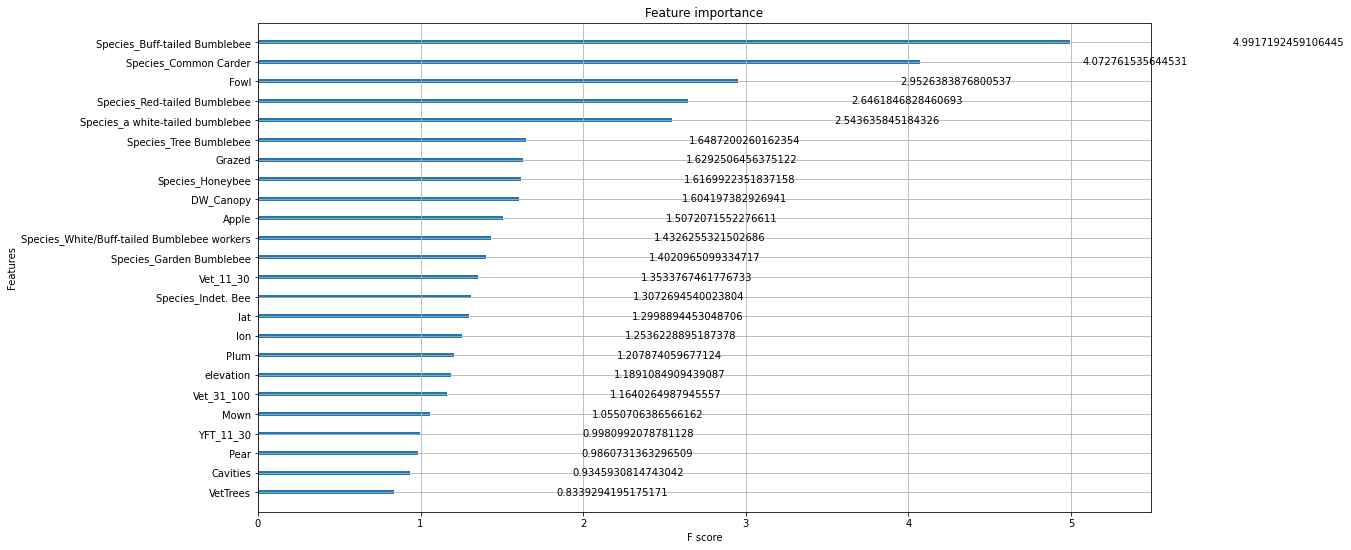

In [181]:
xgb.plot_importance(xg_fit.estimator, importance_type = 'gain')
fig = plt.gcf()
fig.set_size_inches(16, 9)
fig.savefig('Plots/xg_imp.png')
plt.show()

In [206]:
def model_importance(model, title = '', plot = False): #plot for feature importance
    feature_importances = model.estimator_.feature_importances_
    feature_names = model.get_feature_names_out()
    
    sorted_indices = np.argsort(feature_importances)
    sorted_feature_importances = feature_importances[sorted_indices]
    sorted_feature_names = np.array(feature_names)[sorted_indices]
    
    if plot == True:
        plt.figure(figsize=(16, 9), facecolor='white')
        plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, align='center')
        plt.yticks(np.arange(len(sorted_feature_names)), sorted_feature_names)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importance for ' + title)
        plt.savefig('Plots/' + title + '_imp.png', bbox_inches="tight")
        plt.show()
    return sorted_feature_names, sorted_feature_importances

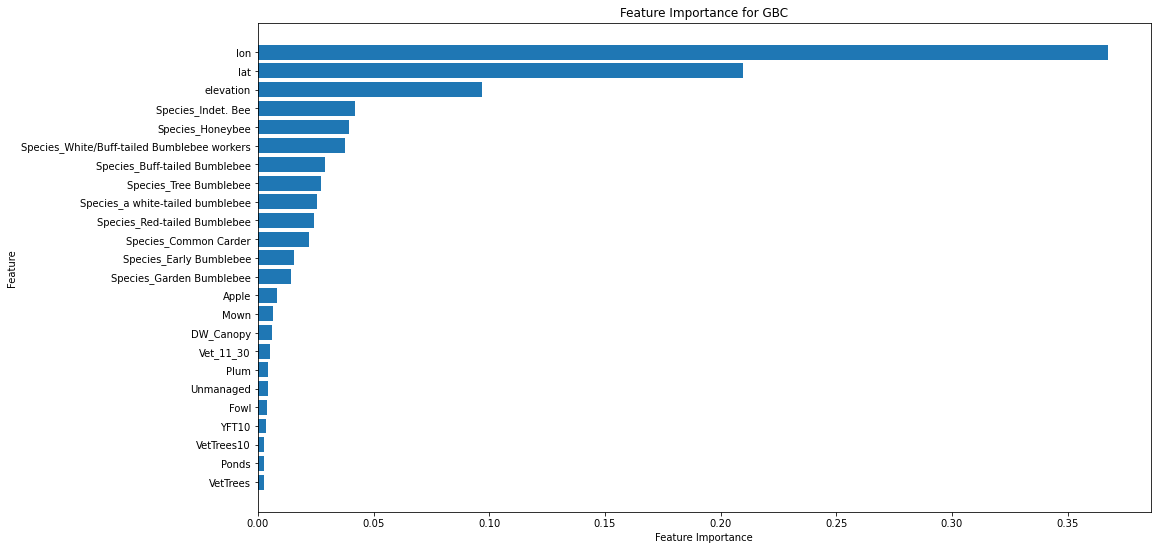

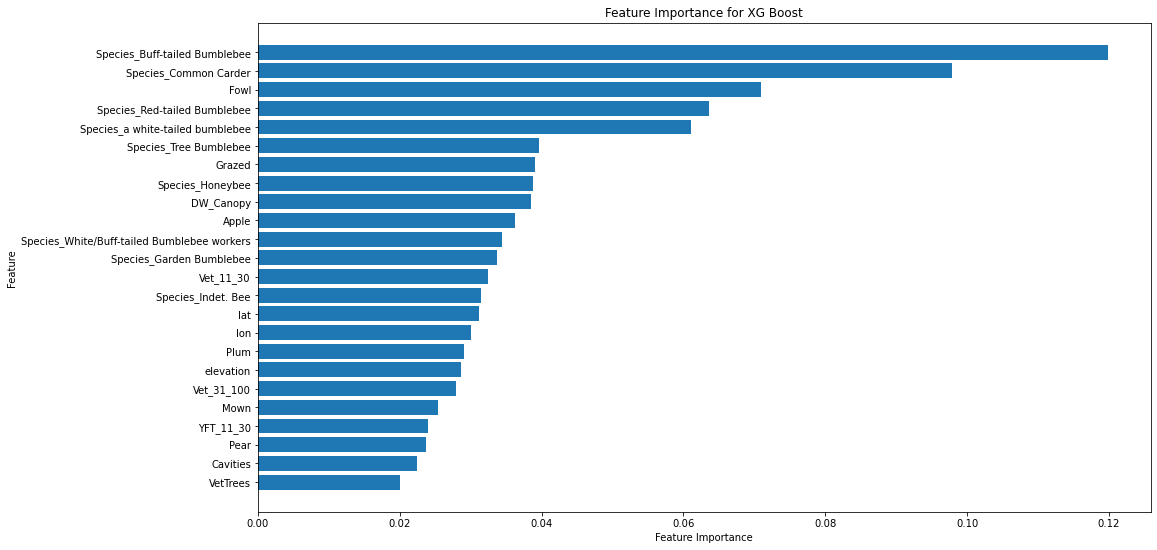

In [193]:
model_importance(gbc_fit, 'GBC')
model_importance(xg_fit, 'XG Boost')

In [223]:
#i used the other rfe models to find their total importances and produce a table
ada_load = joblib.load('Models/ada.pk1')
rf_load = joblib.load('Models/random.pk1')
dec_load = joblib.load('Models/decision.pk1')

ada_fit = fitt(ada_load)
rf_fit = fitt(rf_load)
dec_fit = fitt(dec_load)

imps = pd.DataFrame()
for i in [ada_fit, rf_fit, dec_fit]:
    names, imp = model_importance(i)
    df = pd.DataFrame()
    df['Features'] = names
    df['Importance'] = imp
    imps = pd.concat([df, imps])

imps = imps.groupby(['Features']).sum().sort_values('Importance', ascending=False).reset_index()
dfi.export(imps, 'Plots/other_imp.png')

# Example

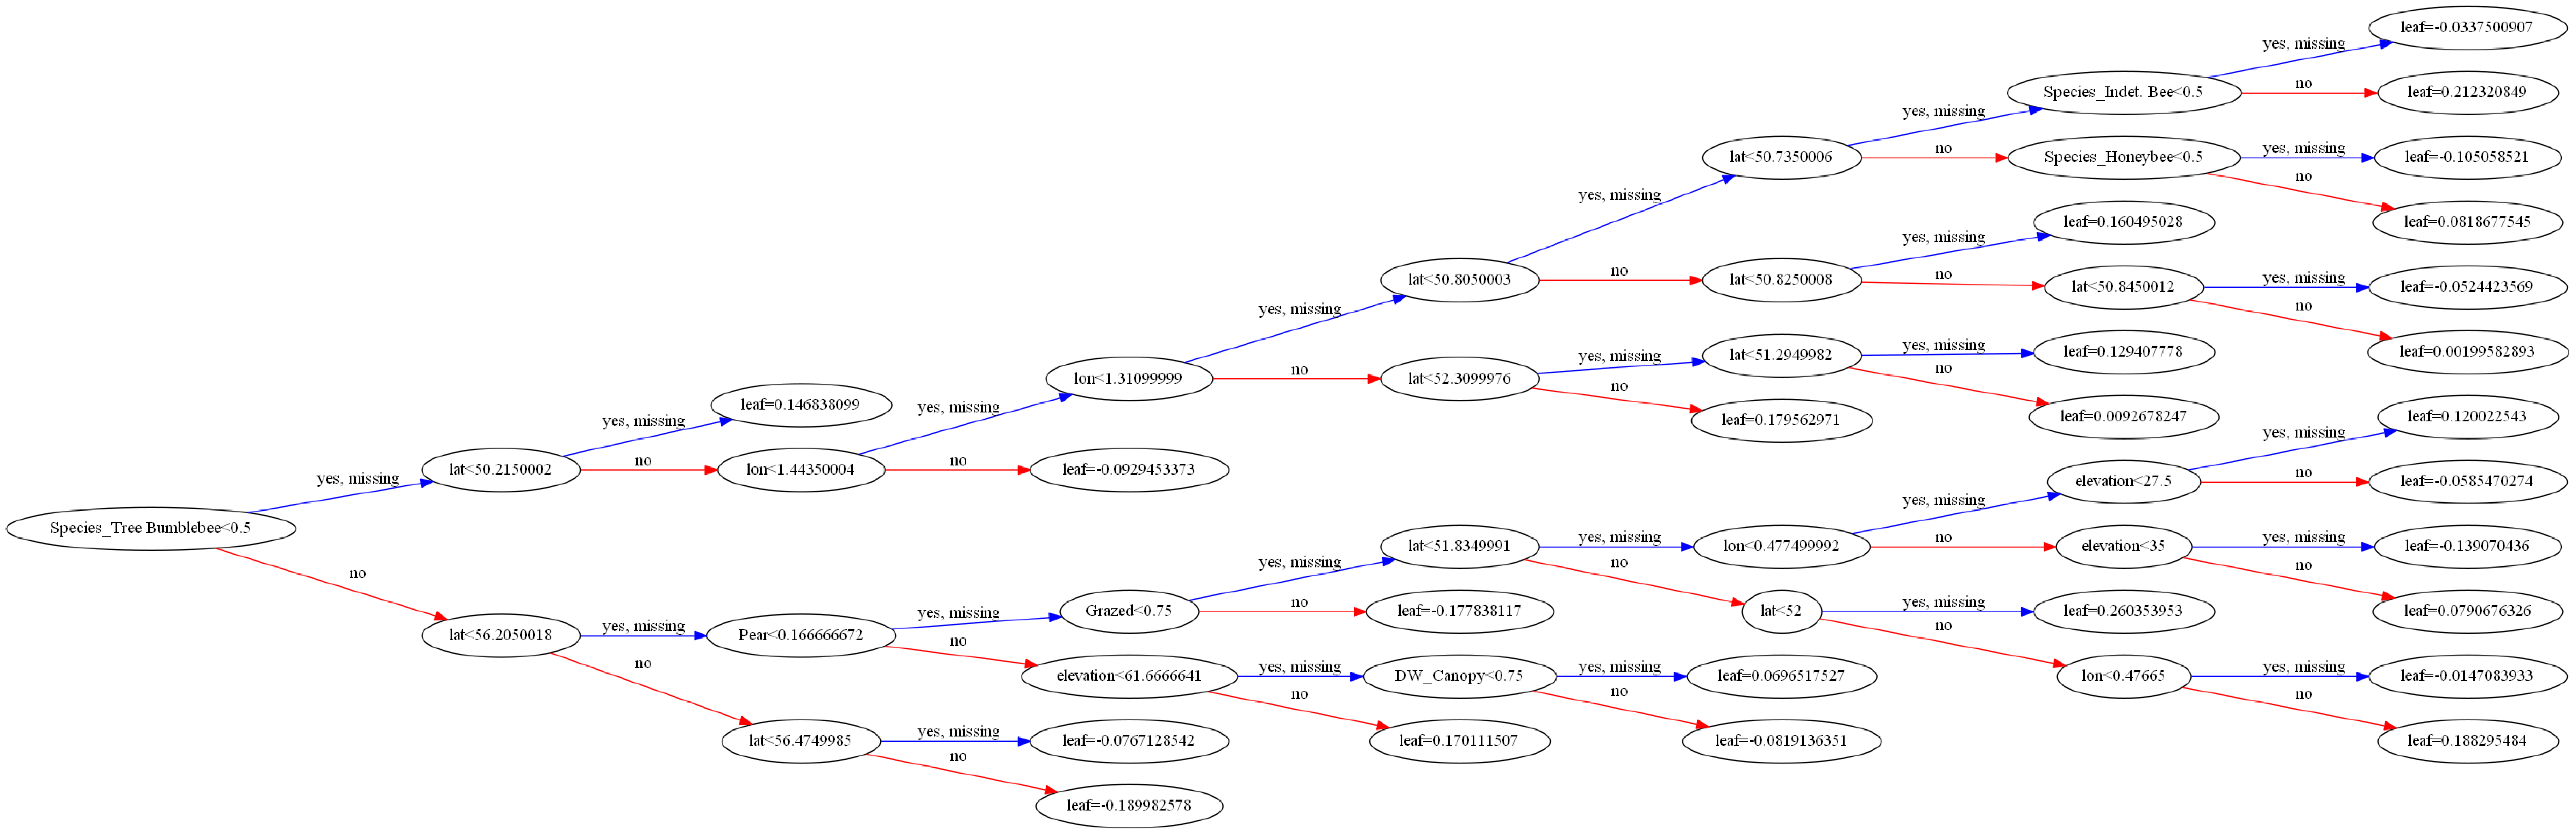

In [52]:
#one the xgb trees
xgb.plot_tree(xg_load.best_estimator_.estimator, num_trees=50, rankdir='LR')
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (1600, 900)
plt.savefig('Plots/tree.png', bbox_inches = 'tight')
plt.show()

# Other Species

In [233]:
species = [x for x in X.columns if x.startswith('Species')] #list of species features

Xy = final_en.drop(columns = ['Total'])

def perSpecies(model): #tests the models against each species individually
    results = []
    for i in species:
        single = Xy.loc[X[i] == 1]
        pred = model.predict(single.drop(columns=['Present']))
        score = accuracy_score(single['Present'], pred)
        results.append([i[8:], score])

    results = pd.DataFrame(results, columns = ['Species', 'Accuracy'])
    return results.sort_values('Accuracy', ascending=False).reset_index(drop = True)

dfi.export(perSpecies(xg_fit), 'Plots/xg_species.png')

dfi.export(perSpecies(gbc_fit), 'Plots/gbc_species.png')

# Evaluation

In [64]:
#plots the confusion matrix and learning curve of the model

scorer = make_scorer(accuracy_score)

def plot_learning_curve(n, est, xs, ys, title):
    train_sizes, train_scores, valid_scores = learning_curve(estimator = est, X = xs, y = ys, cv = n, scoring=scorer)

    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', label='Training score')
    plt.plot(train_sizes, valid_mean, color='green', label='Validation score')
    
    #plt.figure(facecolor='white')
    plt.xlabel('Dataset size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.savefig('Plots/' + title + '.png', bbox_inches="tight")
    plt.show()

def plot_cf(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    disp.plot()
    plt.title(title)
    plt.savefig('Plots/' + title + '.png')
    plt.show()

In [26]:
#loading models
X_xg = xg_load.best_estimator_.transform(X)

X_gbc = gbc_load.best_estimator_.transform(X)

In [ ]:
#producing the plots

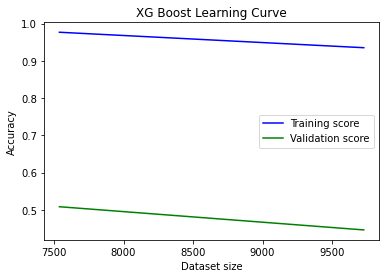

In [42]:
xg_lc = plot_learning_curve(5, xg_load.best_estimator_.estimator, X_xg, y, 'XG Boost Learning Curve')

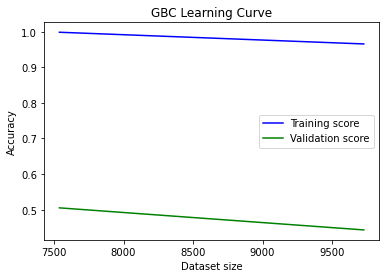

In [43]:
gbc_lc = plot_learning_curve(5, gbc_load.best_estimator_.estimator, X_gbc, y, 'GBC Learning Curve')

In [ ]:
#preparing data using the transformed data from earlier

In [45]:
X_xg_train, X_xg_test, y_xg_train, y_xg_test = train_test_split(X_xg, y, test_size=0.2)

In [46]:
X_gbc_train, X_gbc_test, y_gbc_train, y_gbc_test = train_test_split(X_gbc, y, test_size=0.2)

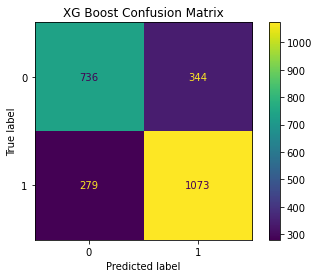

In [65]:
plot_cf(xg_load.best_estimator_.estimator, X_xg_train, y_xg_train, X_xg_test, y_xg_test, 'XG Boost Confusion Matrix')

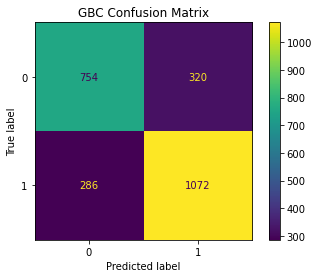

In [66]:
plot_cf(gbc_load.best_estimator_.estimator, X_gbc_train, y_gbc_train, X_gbc_test, y_gbc_test, 'GBC Confusion Matrix')